<a href="https://colab.research.google.com/github/FanmeiWang/AI-AND-MATHS/blob/main/FM%E2%80%94%E2%80%9420250406.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

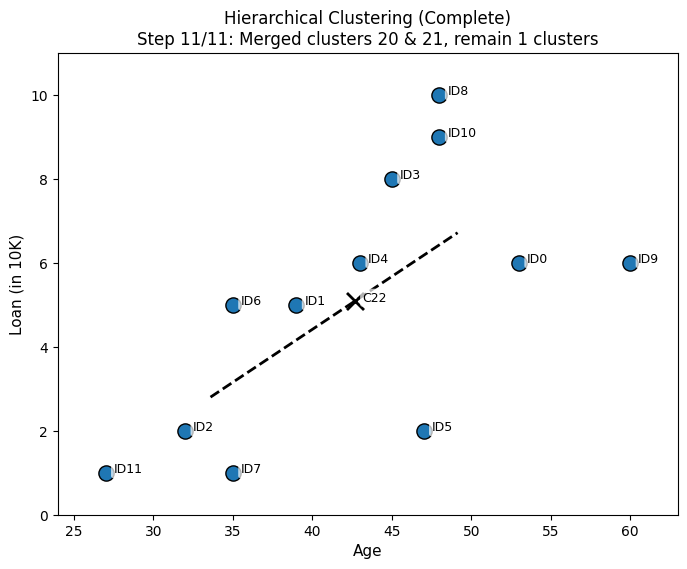

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors

# 1. 生成示例数据 (年龄, 贷款)
np.random.seed(42)
n = 12
Ages = np.random.randint(25, 61, size=n).astype(float)
Loans = np.random.randint(1, 11, size=n).astype(float)  # 1~10万(示意)
X = np.column_stack([Ages, Loans])

Z = linkage(X, method='complete')

# 解析合并序列
merge_steps = []
clusters_dict = {i:[i] for i in range(n)}
current_id = n

for row in Z:
    c1, c2, dist, size = row.astype(int)
    merge_steps.append((c1, c2))
    merged_points = clusters_dict[c1] + clusters_dict[c2]
    clusters_dict[current_id] = merged_points
    del clusters_dict[c1]
    del clusters_dict[c2]
    current_id += 1

def get_clusters_after_step(step):
    local_clusters = {i:[i] for i in range(n)}
    cid = n
    for i in range(step):
        c1, c2 = merge_steps[i]
        pts_c1 = local_clusters.get(c1, [])
        pts_c2 = local_clusters.get(c2, [])
        merged = pts_c1 + pts_c2
        local_clusters[cid] = merged
        if c1 in local_clusters: del local_clusters[c1]
        if c2 in local_clusters: del local_clusters[c2]
        cid += 1
    return local_clusters

def get_center(pts_list):
    coords = X[pts_list]
    return coords.mean(axis=0)

fig, ax = plt.subplots(figsize=(8,6))  # 图像更大一些

cmap_list = list(mcolors.TABLEAU_COLORS.keys())

def update(frame):
    ax.clear()
    clusters_now = get_clusters_after_step(frame)
    cluster_ids = sorted(clusters_now.keys())
    num_clusters = len(cluster_ids)

    if frame > 0:
        c1, c2 = merge_steps[frame-1]
        title_text = f"Step {frame}/{n-1}: Merged clusters {c1} & {c2}, remain {num_clusters} clusters"
    else:
        title_text = f"Step {frame}/{n-1}: No merges yet ({num_clusters} clusters)"

    ax.set_title(f"Hierarchical Clustering (Complete)\n{title_text}", fontsize=12)

    # 画线(上一帧被合并的两个簇中心)
    if frame>0:
        prev_clusters = get_clusters_after_step(frame-1)
        c1_pts = prev_clusters.get(merge_steps[frame-1][0], [])
        c2_pts = prev_clusters.get(merge_steps[frame-1][1], [])
        center1 = get_center(c1_pts)
        center2 = get_center(c2_pts)
        ax.plot([center1[0], center2[0]], [center1[1], center2[1]], 'k--', lw=2)

    # 绘制当前簇
    for idx, cid in enumerate(cluster_ids):
        pts = clusters_now[cid]
        color_name = cmap_list[idx % len(cmap_list)]

        # 绘制簇内点
        for p in pts:
            ax.scatter(X[p,0], X[p,1], c=color_name, s=120, edgecolors='k')
            # 在点附近添加偏移，避免重叠
            ax.text(X[p,0]+0.5, X[p,1], f"ID{p}", fontsize=9, color='black',
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

        # 绘制簇中心
        c_center = get_center(pts)
        ax.scatter(c_center[0], c_center[1], marker='x', c='black', s=150, linewidths=2)
        ax.text(c_center[0]+0.5, c_center[1], f"C{cid}", fontsize=9, color='black',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

    ax.set_xlabel("Age", fontsize=11)
    ax.set_ylabel("Loan (in 10K)", fontsize=11)

    # 预留一点空间,以免文字出界
    x_min, x_max = np.min(X[:,0]) - 3, np.max(X[:,0]) + 3
    y_min, y_max = np.min(X[:,1]) - 1, np.max(X[:,1]) + 1
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, update, frames=n, interval=1500, repeat=False)
anim.save("hc_cluster_readable.gif", writer='pillow', fps=1)
plt.show()



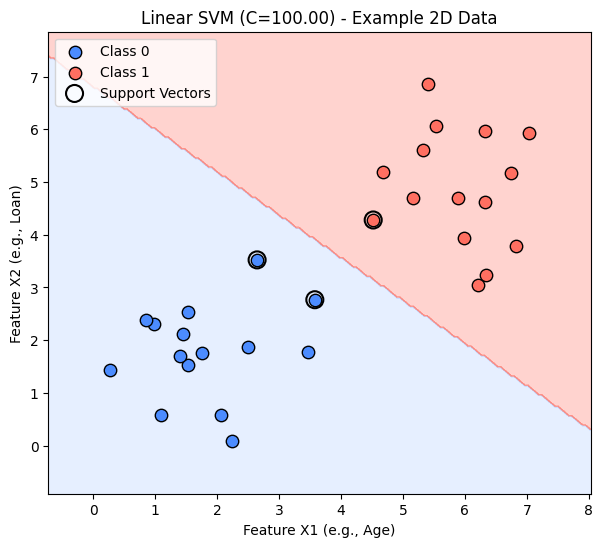

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap  # 新增这一行

# ---------------------------
# 1. Generate a two-class dataset
# ---------------------------
np.random.seed(42)
X_class0 = np.random.randn(15, 2) + [2, 2]
X_class1 = np.random.randn(15, 2) + [6, 5]
X = np.vstack([X_class0, X_class1])
y = np.array([0]*15 + [1]*15)

# We'll vary C to see how the margin changes
C_values = np.logspace(-2, 2, 10)  # from 0.01 to 100

# Prepare a grid for plotting
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

fig, ax = plt.subplots(figsize=(7,6))

# ✅ 使用自定义双色 colormap（牛仔蓝 & 珊瑚红）
cmap_regions = ListedColormap(["#AFCBFF", "#FF6F61"])

def train_and_plot(C):
    """
    Train an SVM with the given C, then plot decision boundary & support vectors.
    """
    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y)

    # Predict over grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the classification regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_regions)

    # Plot the two classes separately using清爽风格
    class0 = (y == 0)
    class1 = (y == 1)
    ax.scatter(X[class0,0], X[class0,1], c='#4C8CFF',
               label='Class 0', edgecolors='k', s=80)
    ax.scatter(X[class1,0], X[class1,1], c='#FF6F61',
               label='Class 1', edgecolors='k', s=80)

    # Mark support vectors
    sv = clf.support_vectors_
    ax.scatter(sv[:,0], sv[:,1], s=150, facecolors='none',
               edgecolors='k', linewidth=1.5, label='Support Vectors')

    ax.set_title(f"Linear SVM (C={C:.2f}) - Example 2D Data")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("Feature X1 (e.g., Age)")
    ax.set_ylabel("Feature X2 (e.g., Loan)")
    ax.legend(loc='upper left')

def update(frame):
    ax.clear()
    C = C_values[frame]
    train_and_plot(C)

anim = FuncAnimation(fig, update, frames=len(C_values), interval=1200, repeat=False)

# Save as GIF (optional)
anim.save("svm_margin_vibrant.gif", writer='pillow', fps=1)

plt.show()

